/var/folders/h1/07v9m7ld23b1sjfyjxm7fcdh0000gn/T/ipykernel_40269/2181309216.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sales'] = data['sales'].apply(np.log1p)


<AxesSubplot:xlabel='date'>

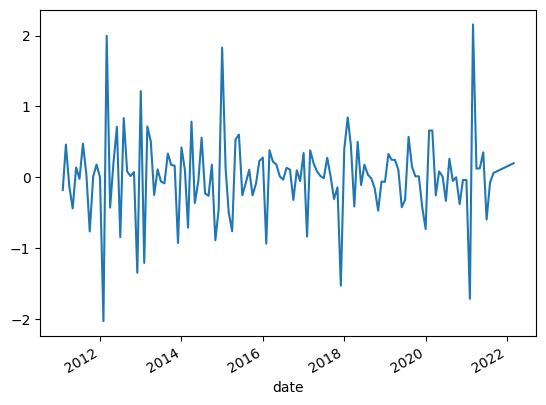

In [4]:
import numpy as np 
import pandas as pd
import warnings
from matplotlib import pyplot as plt 
file_path = './source_data/A4backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','values','sales']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)

# data['sales'].plot()
# raw_data['sales'].plot()

def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]

diff_data[0].plot()

In [7]:
import numpy as np 
import pandas as pd
import warnings
from matplotlib import pyplot as plt 
file_path = './source_data/A4backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
data = raw_data[['date','sales']]
# data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)

data

,sales
date,
2011-01-01,495.268
2011-02-01,412.960
2011-03-01,654.560
2011-04-01,572.284
2011-05-01,368.036
...,...
2021-06-01,1524.080
2021-07-01,838.668
2021-08-01,777.760


In [ ]:
# use xgboost


import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from prophet import Prophet
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
import xgboost as xgb

file_path = './source_data/A4backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-3]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]


def train_xgboost(data,in_windows,out_windows,train_num):
    X = []
    y = []
    L = len(data)
    for i in range(L):
        if i+in_windows+out_windows > L:
            break
        X.append(data[i:i+in_windows])
        y.append(data[i+in_windows:i+in_windows+out_windows])
    X = np.array(X)
    y = np.array(y)
    X_train,y_train,X_test,y_test= X[:train_num],y[:train_num],X[train_num:],y[train_num:]
    model = xgb.XGBRegressor(n_estimators=100,learning_rate=0.1,early_stopping_rounds=50)
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)])
    test_pred = model.predict(X_test).reshape(-1,out_windows)
    print(test_pred)
    print("xgb r2:",r2_score(y_test,test_pred))
    print("xgb mse:",mean_squared_error(y_test,test_pred))
    print("xgb mae:",mean_absolute_error(y_test,test_pred))
    train_pred = model.predict(X_train).reshape(-1,out_windows)
    res = []
    for i in train_pred :
        res.append(i[0])
    for i in test_pred :
        res.append(i[0])
    return res

def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)


in_window_size,out_window_size = 4,4
input_data = diff_data[0:]
data_predict = train_xgboost(input_data[0],in_window_size,out_window_size,train_num=80)

data_true = input_data[in_window_size+out_window_size-1:]


inverse_predict =  inverse_difference(input_data[:in_window_size].sum().values[0]+data['sales'][0],data_predict)
inverse_predict = inverse_predict.apply(np.expm1)

inverse_true  = inverse_difference(input_data[:in_window_size].sum().values[0]+data['sales'][0],data_true[0])
inverse_true = inverse_true.apply(np.expm1)

print("raw r2:",r2_score(inverse_true[0],inverse_predict[0]))
print("raw mse:",mean_squared_error(inverse_true[0],inverse_predict[0]))
print("raw mase:",mean_absolute_error(inverse_true[0],inverse_predict[0]))

inverse_predict[0].plot(marker='x')
inverse_true[0].plot(marker='o')



